### Libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix , accuracy_score , precision_score , recall_score , f1_score

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import mutual_info_regression, SelectPercentile, chi2, f_classif, SelectKBest

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [113]:
from joblib import Parallel, delayed

In [114]:
import joblib

### Import Dataset

In [115]:
# import the csv
model_train = pd.read_csv('dataset_B_05_2020.csv')

In [116]:
model_train.isnull().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

### Feature Engineering

In [117]:
model_train['total_special_chars'] = model_train[['nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 
                                                  'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 
                                                  'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space']].sum(axis=1)

In [118]:
model_train['sum_common_terms'] = model_train['nb_www'] + model_train['nb_com'] + model_train['nb_dslash'] + model_train['http_in_path']

### Encoding

In [119]:
lb = LabelBinarizer()

In [120]:
# Transform status column to binary labels
model_train['status'] = lb.fit_transform(model_train['status'])

### Select Numerical Features

In [121]:
numerical_features = model_train.select_dtypes(include=np.number).columns.tolist()

In [122]:
numerical_features.pop(-1)

'sum_common_terms'

### Scale

In [123]:
# Create a StandardScaler object
scaler = StandardScaler()
scaler.fit(model_train[numerical_features])
scaled_features = scaler.transform(model_train[numerical_features])

In [124]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [125]:
model_train[numerical_features] = scaled_features

### Correlation

In [126]:
corr_matrix = model_train.corr()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20,20))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, ax=ax)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Show plot
plt.show()

### Split into Train and Test

In [127]:
X = model_train.drop(['url', 'status'], axis=1)
y = model_train['status']

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=3, shuffle=True)

### MODEL CLASS

In [219]:
class ModelTester:
    def __init__(self, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=3)):
        self.X_train = X_train
        self.y_train = y_train
        self.cv = cv

    def test_models(self):
        models = {
            'SVM': SVC(),
            'Gaussian Naive Bayes': GaussianNB(),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        
        evaluation_metrics = ['accuracy', 'f1', 'precision', 'recall']
        
        results_dict = {}
        
        for model_name, model in models.items():
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            
            param_grid = {}
            
            if model_name == 'SVM':
                param_grid = {
                    'model__C': [0.1, 1, 10],
                    'model__kernel': ['linear', 'rbf', 'poly'],
                    'model__degree': [2, 3, 4],
                    'model__gamma': ['scale', 'auto']
                }
            elif model_name == 'Decision Tree':
                param_grid = {
                    'model__criterion': ['gini', 'entropy'],
                    'model__max_depth': [2, 4, 6, 8, 10, 12],
                    'model__min_samples_split': [2, 5, 10],
                    'model__min_samples_leaf': [1, 2, 4]
                }
            elif model_name == 'Random Forest':
                param_grid = {
                    'model__n_estimators': [50, 100, 200],
                    'model__criterion': ['gini', 'entropy'],
                    'model__max_depth': [2, 4, 6, 8, 10, 12],
                    'model__min_samples_split': [2, 5, 10],
                    'model__min_samples_leaf': [1, 2, 4],
                    'model__bootstrap': [True, False]
                }
            elif model_name == 'Logistic Regression':
                param_grid = {
                    'model__C': [0.1, 1, 10],
                    'model__penalty': ['l1', 'l2'],
                    'model__solver': ['liblinear']
                }
            else:
                param_grid = {}
        
            search = GridSearchCV(pipe, param_grid, cv=self.cv, scoring='accuracy', n_jobs=-1)
            search.fit(self.X_train, self.y_train)

            print(f"Best parameters for {model_name}:")
            print(search.best_params_)
            print(f"Best cross-validation score for {model_name}:")
            print(search.best_score_)
            print('\n')
            
            # evaluate each model
            y_pred = search.best_estimator_.predict(self.X_train)
            results = {}
            for metric in evaluation_metrics:
                if metric == 'accuracy':
                    results[metric] = accuracy_score(self.y_train, y_pred)
                elif metric == 'f1':
                    results[metric] = f1_score(self.y_train, y_pred, average='macro')
                elif metric == 'precision':
                    results[metric] = precision_score(self.y_train, y_pred, average='macro')
                elif metric == 'recall':
                    results[metric] = recall_score(self.y_train, y_pred, average='macro')
            
             # add confusion matrix to results
            conf_matrix = confusion_matrix(self.y_train, y_pred)
            results['confusion_matrix'] = conf_matrix
            
            # save evaluation results for each model
            results_dict[model_name] = results
        
        # create dataframe from results dictionary
        df = pd.DataFrame.from_dict(results_dict, orient='index')
        df.index.name = 'model_name'
        
        return df


In [220]:
model_tester = ModelTester(X_train, y_train)
results_df = model_tester.test_models()

# display the results for both models
results_df.reset_index(inplace=True)
results_df.rename(columns={'accuracy': 'accuracy_score',
                           'f1': 'f1_score',
                           'precision': 'precision_score',
                           'recall': 'recall_score',
                           'confusion_matrix': 'confusion_matrix'},
                  inplace=True)
results_df = results_df[['model_name', 'accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'confusion_matrix']]
print(results_df)

Best parameters for SVM:
{'model__C': 10, 'model__degree': 2, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best cross-validation score for SVM:
0.9605209887384504


Best parameters for Gaussian Naive Bayes:
{}
Best cross-validation score for Gaussian Naive Bayes:
0.6843860702779078


Best parameters for Decision Tree:
{'model__criterion': 'gini', 'model__max_depth': 12, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
Best cross-validation score for Decision Tree:
0.9419293225004874


Best parameters for Random Forest:
{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': 12, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best cross-validation score for Random Forest:
0.9663168643290148


Best parameters for Logistic Regression:
{'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best cross-validation score for Logistic Regression:
0.9451012917343121


             model_name  accuracy_sco

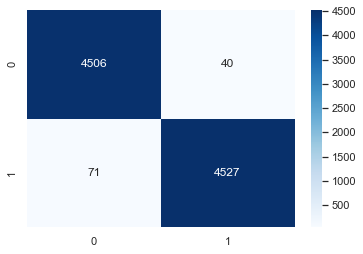

In [221]:
# display only the results for the Decision Tree model
dt_results_df = results_df.loc[results_df['model_name'] == 'SVM']
conf_matrix = dt_results_df['confusion_matrix'].values[0]

# create a heatmap with seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

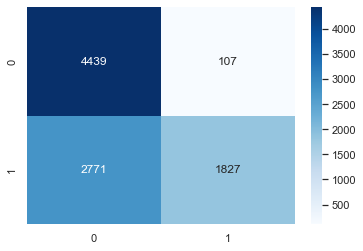

In [222]:
# display only the results for the Decision Tree model
dt_results_df = results_df.loc[results_df['model_name'] == 'Gaussian Naive Bayes']
conf_matrix = dt_results_df['confusion_matrix'].values[0]

# create a heatmap with seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

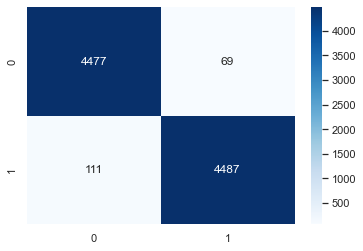

In [223]:
# display only the results for the Decision Tree model
dt_results_df = results_df.loc[results_df['model_name'] == 'Decision Tree']
conf_matrix = dt_results_df['confusion_matrix'].values[0]

# create a heatmap with seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.savefig('Decision.png')

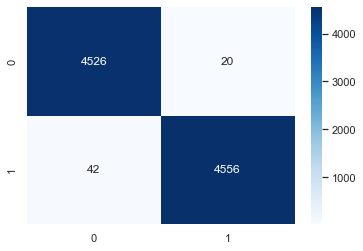

In [224]:
# display only the results for the Decision Tree model
dt_results_df = results_df.loc[results_df['model_name'] == 'Random Forest']
conf_matrix = dt_results_df['confusion_matrix'].values[0]

# create a heatmap with seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.savefig('Random.png')

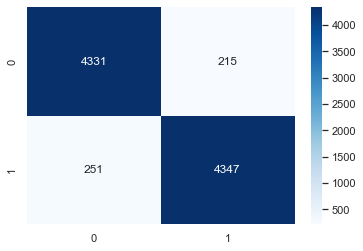

In [225]:
# display only the results for the Decision Tree model
dt_results_df = results_df.loc[results_df['model_name'] == 'Logistic Regression']
conf_matrix = dt_results_df['confusion_matrix'].values[0]

# create a heatmap with seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.savefig('Logistic.png')